In [31]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import warnings
import chainladder as cl # Sparse=0.14.0 ; incremental.py np.NINF -> -np.inf
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [32]:
def claims_formatter(doc:pd.DataFrame):
    doc_copy = doc.copy()
    
    #Acomodo indice
    doc_copy.index = doc_copy.AUTOMOTORES
    formatted_doc = doc_copy.iloc[:,4:].stack(level = [0,1,2,3]).reset_index([1,2,3,4]).drop_duplicates()
    formatted_doc.reset_index(inplace = True)
    formatted_doc[['Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']] = pd.DataFrame(formatted_doc[('index','')].to_list(), index = formatted_doc.index)

    #Acomodo columnas
    formatted_doc.columns = ['indice','Tipo', 'Periodo', 'Desarrollo 1', 'Año Valuacion', 'Pendientes', 'Pagados', 'Incurridos', 'Cantidad', 'Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']
    formatted_doc['Año Ocurrencia'] = pd.to_datetime(formatted_doc['Periodo'][0][0:5]) + pd.DateOffset(months = 6)
    formatted_doc['Año Valuacion'] = pd.to_datetime(formatted_doc['Año Valuacion'])
    #formatted_doc['Desarrollo'] = formatted_doc['Año Valuacion'] - formatted_doc['Año Ocurrencia']
    formatted_doc.drop(['indice','Tipo', 'Periodo', 'Desarrollo 1'], axis = 1, inplace = True)

    return formatted_doc

def check_chainladdes_assumptions( triangle:cl.Triangle, columns:list):
    for column in columns:
        if triangle[column].sum().valuation_correlation(p_critical=0.1, total=True).z_critical.values == True:
            print(f'Triangulo {column}: Años de valuación correlacionados')
        elif triangle[column].sum().development_correlation(p_critical=0.1).t_critical.values == False:
            print(f'Triangulo {column}: Años de desarrollo no correlacionados')
    return 0


def rgaa_chainladder(triang_stos_act:cl.Triangle):

    #Valores Actuales
    latest_diag = triang_stos_act['Incurridos'].incr_to_cum().latest_diagonal.to_frame()  

    #Modelo CL
    pipe_rgaa = cl.Pipeline(steps=[
        ("development", cl.Development(average="volume")),
        ("tail", cl.TailConstant(tail=1.05, decay = 1)),
        ('cl_model', cl.Chainladder() ),    
    ])

    triang_rgaa = pipe_rgaa.fit(triang_stos_act['Incurridos'].incr_to_cum())

    #CDFs & Ultimate
    cl_triang = triang_rgaa.named_steps.cl_model.full_triangle_.to_frame()
    cl_cdfs = triang_rgaa.named_steps.cl_model.cdf_.to_frame().melt()

    cl_ultimate = cl_triang.iloc[:,len(cl_triang.columns)-1]
    cl_cdfs = cl_cdfs[len(cl_cdfs)-2::-1].set_index(latest_diag.index, drop = True )

    #Concateno todo
    result = pd.concat([latest_diag, cl_cdfs['value'], cl_ultimate], axis = 1)
    result.columns = ['Actual', 'FDA', 'Ultimate']
    result['IBNR'] = result['Ultimate'] - result['Actual']

    return result, triang_rgaa.named_steps.cl_model.full_triangle_.to_frame(), triang_rgaa.named_steps.cl_model.expected_triangle_.to_frame()
            

In [33]:
sto_input = pd.read_excel('..\\sample\\ssn_20192020_desarrollo_siniestros_automotores.xlsx', sheet_name = None, header=[0,1,2,3,4,5])
facpce_input = pd.read_excel('..\\sample\\Indice-FACPCE-Res.-JG-539-18-_2025-07-1.xlsx', skiprows = 2, skipfooter=4)

#Tratamiendo desarrollo de stos
#sto_input = dict(itertools.islice(sto_input.items(), 3, len(sto_input)))
sto_input_formateado = [claims_formatter(sto_input[k]) for k in sto_input.keys() if (k[0] == '2') or (k[0] == '1')]
db_stos = pd.concat(sto_input_formateado)

#Tratamiento indice facpce
db_facpce = facpce_input.set_index('MES')
factores_facpce = db_facpce.loc[max(db_stos['Año Valuacion']) - pd.DateOffset(days = 29)] / db_facpce.loc[db_stos['Año Valuacion'] - pd.DateOffset(months = 5, days = 29)] # Asumo que esta todo valuado a mitad de periodo.
db_stos['Factor FACPSE'] = factores_facpce.set_index(db_stos.index)

#Armo el dataframe para el triángulo que quiero analizar 
idx = (db_stos['Base Origen'] == '[HG]')
db_triangle = db_stos.loc[idx, ['Año Ocurrencia', 'Año Valuacion', 'Pendientes','Pagados' , 'Incurridos', 'Factor FACPSE', 'Cantidad', 'Ramo']]
db_triangle['Año Valuacion'] = db_triangle['Año Valuacion'] + pd.DateOffset(months = -6)
db_triangle['Año Ocurrencia'] = db_triangle['Año Ocurrencia'] + pd.DateOffset(months = -6)

In [34]:
fecha_corte = pd.Timestamp(year = 2008,month = 1,day = 1)
db_triangle_train =db_triangle # .loc[(db_triangle['Año Ocurrencia'] < fecha_corte) & (db_triangle['Año Valuacion'] <= fecha_corte),:]

In [35]:

#Chequeo supuestos para Cl y aplico el factor FACPCE
triang_stos = cl.Triangle(db_triangle_train, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = ['Pagados', 'Pendientes', 'Incurridos', 'Cantidad'], index=['Ramo'], cumulative = True)
triang_facpce = cl.Triangle(db_triangle_train, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = 'Factor FACPSE', index = ['Ramo'])
triang_stos_act = triang_stos.cum_to_incr() * triang_facpce
#check_chainladdes_assumptions(triang_stos_act, ['Pagados', 'Pendientes', 'Incurridos'])

In [36]:
triang_facpce[triang_facpce['Ramo']=='RC'].heatmap()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240,252,264
1998,42.0432,40.8654,40.3713,40.0948,19.4845,19.2562,17.9637,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109
1999,40.8654,40.3713,40.0948,19.4845,19.2562,17.9637,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,
2000,40.3713,40.0948,19.4845,19.2562,17.9637,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,
2001,40.0948,19.4845,19.2562,17.9637,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,,
2002,19.4845,19.2562,17.9637,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,,,
2003,19.2562,17.9637,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,,,,
2004,17.9637,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,,,,,
2005,15.8653,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,,,,,,
2006,14.9523,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,,,,,,,
2007,12.9952,12.0462,10.7704,9.4251,8.3763,7.4000,6.2063,5.0680,3.9756,3.1695,2.5355,1.6981,1.1109,,,,,,,,,


In [37]:
df_triang = triang_stos['Incurridos'].to_frame(keepdims=True)
#df_triang.columns = np.arange(len(df_triang.columns))+1
df_triang['development'] = df_triang['development']/12
#df_triang.to_csv('..\\sample\\ssn_20192020_desarrollo_siniestros_automotores.csv', encoding='latin-1')

In [38]:
df_triang.loc['Total']

,origin,development,Incurridos
Ramo,,,
Total,1998-01-01,1.0,1.241932e+09
Total,1998-01-01,2.0,7.912098e+08
Total,1998-01-01,3.0,1.590001e+09
Total,1998-01-01,4.0,1.660060e+09
Total,1998-01-01,5.0,1.776665e+09
...,...,...,...
Total,2017-01-01,2.0,1.189955e+11
Total,2017-01-01,3.0,1.262607e+11
Total,2018-01-01,1.0,1.358097e+11


In [39]:
#resultados_rgaa = rgaa_chainladder(triang_stos_act)
#resultados_rgaa

In [40]:
raa = triang_stos_act
model = cl.Development().fit(triang_stos_act)
#model.std_residuals_

In [41]:
triang_stos[triang_stos['Ramo']=='RC']['Cantidad'].cum_to_incr().heatmap()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240,252,264
1998,"421,295","19,592","2,765",815,276,169,83,36,8,444,698,83,17,17,25,12,10,3,7,4,3,2
1999,"445,413","18,430","1,596",473,266,101,127,12,"1,171","1,151",117,49,20,31,24,26,-3,4,4,9,5,
2000,"501,699","19,764","1,318",570,192,212,29,"1,140","1,279",60,109,30,46,37,26,13,9,12,7,5,,
2001,"465,120","19,684","1,766",287,275,57,"1,525","1,194",101,58,50,108,45,31,24,25,27,16,20,,,
2002,"448,063","19,418","1,672",430,61,"2,033","1,114",103,63,27,33,46,27,12,8,13,10,1,,,,
2003,"514,255","21,544","1,382",302,"3,382","1,043",163,65,38,26,117,37,19,17,25,10,1,,,,,
2004,"608,657","25,501","1,293","8,087","1,457",312,120,68,35,153,50,28,12,25,8,5,,,,,,
2005,"677,285","30,424","37,449","2,486",420,180,108,47,199,70,51,26,37,11,10,,,,,,,
2006,"766,312","78,349","32,852",980,353,189,74,365,84,75,46,32,24,13,,,,,,,,
2007,"956,302","42,627","3,586","1,041",362,137,586,141,74,39,37,34,19,,,,,,,,,


In [42]:
triang_stos[triang_stos['Ramo']=='RC']['Cantidad'].link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144,144-156,156-168,168-180,180-192,192-204,204-216,216-228,228-240,240-252,252-264
1998,1.0465,1.0063,1.0018,1.0006,1.0004,1.0002,1.0001,1.0000,1.0010,1.0016,1.0002,1.0000,1.0000,1.0001,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1999,1.0414,1.0034,1.0010,1.0006,1.0002,1.0003,1.0000,1.0025,1.0025,1.0002,1.0001,1.0000,1.0001,1.0001,1.0001,1.0000,1.0000,1.0000,1.0000,1.0000,
2000,1.0394,1.0025,1.0011,1.0004,1.0004,1.0001,1.0022,1.0024,1.0001,1.0002,1.0001,1.0001,1.0001,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,,
2001,1.0423,1.0036,1.0006,1.0006,1.0001,1.0031,1.0024,1.0002,1.0001,1.0001,1.0002,1.0001,1.0001,1.0000,1.0001,1.0001,1.0000,1.0000,,,
2002,1.0433,1.0036,1.0009,1.0001,1.0043,1.0024,1.0002,1.0001,1.0001,1.0001,1.0001,1.0001,1.0000,1.0000,1.0000,1.0000,1.0000,,,,
2003,1.0419,1.0026,1.0006,1.0063,1.0019,1.0003,1.0001,1.0001,1.0000,1.0002,1.0001,1.0000,1.0000,1.0000,1.0000,1.0000,,,,,
2004,1.0419,1.0020,1.0127,1.0023,1.0005,1.0002,1.0001,1.0001,1.0002,1.0001,1.0000,1.0000,1.0000,1.0000,1.0000,,,,,,
2005,1.0449,1.0529,1.0033,1.0006,1.0002,1.0001,1.0001,1.0003,1.0001,1.0001,1.0000,1.0000,1.0000,1.0000,,,,,,,
2006,1.1022,1.0389,1.0011,1.0004,1.0002,1.0001,1.0004,1.0001,1.0001,1.0001,1.0000,1.0000,1.0000,,,,,,,,
2007,1.0446,1.0036,1.0010,1.0004,1.0001,1.0006,1.0001,1.0001,1.0000,1.0000,1.0000,1.0000,,,,,,,,,


In [46]:
triang_stos_act[triang_stos_act['Ramo']=='RC']['Incurridos'].incr_to_cum().link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144,144-156,156-168,168-180,180-192,192-204,204-216,216-228,228-240,240-252,252-264
1998,1.4652,1.0160,1.0710,1.0503,1.0250,1.0185,1.0110,1.0105,1.0095,0.9814,1.0194,1.0019,0.9995,0.9997,1.0063,1.0020,1.0024,1.0016,1.0016,1.0013,1.0003
1999,1.3463,1.1153,1.0651,1.0310,1.0108,1.0324,1.0176,1.0098,0.9751,1.0334,0.9996,0.9947,1.0040,1.0049,1.0061,1.0032,1.0063,1.0054,1.0034,0.9984,
2000,1.4988,1.0609,1.0323,1.0222,1.0303,1.0231,1.0210,0.9819,1.0016,1.0263,1.0016,0.9957,1.0098,1.0088,1.0154,1.0057,1.0044,1.0014,1.0025,,
2001,1.2795,1.0619,1.0374,1.0348,1.0281,1.0218,0.9874,1.0103,1.0102,1.0248,0.9953,1.0106,1.0128,1.0042,1.0031,1.0024,1.0017,1.0009,,,
2002,1.4643,1.0676,1.0807,1.0346,1.0424,0.9885,1.0201,1.0209,1.0096,1.0198,1.0120,1.0072,1.0154,1.0043,1.0137,1.0067,1.0052,,,,
2003,1.4046,1.1117,1.0670,1.0485,0.9993,1.0326,1.0173,1.0169,1.0221,1.0314,1.0102,1.0146,1.0099,1.0114,1.0030,1.0072,,,,,
2004,1.3870,1.0615,1.0654,1.0184,1.0374,1.0187,1.0063,1.0142,1.0143,1.0340,1.0206,1.0097,1.0117,1.0039,1.0039,,,,,,
2005,1.4122,1.0703,1.0658,1.0473,1.0248,1.0190,1.0220,1.0321,1.0287,1.0206,1.0670,1.0144,1.0114,1.0079,,,,,,,
2006,1.4687,1.0990,1.0800,1.0227,1.0207,1.0269,1.0424,1.0312,1.0351,1.0331,1.0145,1.0056,1.0113,,,,,,,,
2007,1.5110,1.1142,1.0469,1.0318,1.0364,1.0388,1.0443,1.0399,1.0392,1.0176,1.0111,1.0094,,,,,,,,,


In [ ]:
triang_stos_act['Incurridos'].incr_to_cum().link_ratio.heatmap()
triang_stos_act[triang_stos['Ramo']=='RC']['Pagados'].incr_to_cum().link_ratio.heatmap()
triang_stos_act['Pendientes'].incr_to_cum().link_ratio.heatmap()

ValueError: heatmap() only works with a single triangle

In [13]:
tail = cl.TailCurve(curve='inverse_power', extrap_periods = 5).fit(triang_stos_act['Pagados'].incr_to_cum())
tail.ldf_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144
(All),1.6936,1.1415,1.0917,1.0718,1.0566,1.0442,1.0311,1.0229,1.0197,1.0175,1.0518


In [14]:
pipe_dev = cl.Pipeline(steps=[
     ("simple_dev", cl.Development(average="volume")),
    ("inverse_power_tail", cl.TailCurve(curve="inverse_power", extrap_periods=5)),
    ('cl_model', cl.Chainladder() ),
    ]).fit(triang_stos_act['Pagados'].incr_to_cum())
pipe_dev.named_steps.cl_model.full_triangle_.valuation_date

Timestamp('2261-12-31 23:59:59.999999999')

In [15]:
#Triangulo con predicciones
pipe_dev.named_steps.cl_model.full_triangle_

#Triagulo predecido
pipe_dev.named_steps.cl_model.full_expectation_

#Diferencia
triang_heat = triang_stos_act['Pagados'].incr_to_cum() - pipe_dev.named_steps.cl_model.full_expectation_
triang_heat[triang_heat.valuation <= triang_stos_act['Pagados'].valuation_date].heatmap()

,12,24,36,48,60,72,84,96,108,120
2011,"-2,760,370,966","-826,922,894","-1,175,309,712","-1,591,365,240","-1,869,335,427","-1,326,615,486","-399,942,213","71,034,356",,
2012,"-2,990,735,179","-1,707,132,928","-1,208,666,565","-1,228,120,343","-730,758,152","49,050,660","44,820,977","-71,034,356",0,
2013,"-3,156,906,095","-1,270,165,342","-799,917,460","-437,537,733","673,600,479","934,834,930","355,121,236",,,
2014,"-1,193,515,109","-665,769,703","-186,525,494","877,854,248","1,078,038,510","342,729,896",,,,
2015,"-209,237,547","706,527,798","1,418,607,933","1,640,915,324","848,454,589",,,,,
2016,"2,057,045,356","2,402,559,180","1,761,577,544","738,253,744",0,,,,,
2017,"2,254,923,015","1,321,418,664","190,233,755",,,,,,,
2018,"3,555,240,836","39,485,225",0,,,,,,,
2019,"2,443,555,690",,,,,,,,,
2020,,,,,,,,,,


In [17]:
comauto = cl.load_sample("clrd").groupby("LOB").sum().loc["comauto"]

bf_model = cl.BornhuetterFerguson(apriori=0.75)
bf_model.fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

,apriori,0.75
,apriori_sigma,0.0
,random_state,None


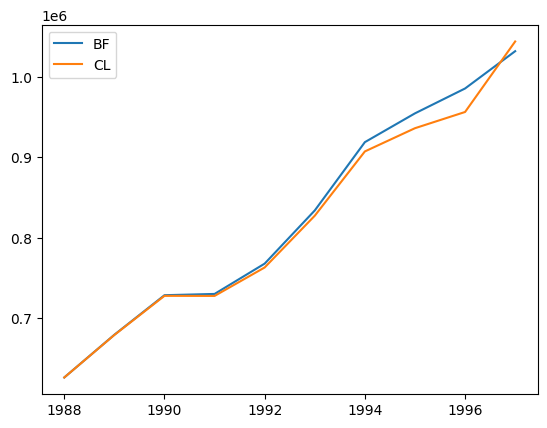

In [18]:
plt.plot(
    bf_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    bf_model.ultimate_.to_frame(origin_as_datetime=True),
    label="BF",
)

cl_model = cl.Chainladder().fit(comauto["CumPaidLoss"])
plt.plot(
    cl_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    cl_model.ultimate_.to_frame(origin_as_datetime=True),
    label="CL",
)

plt.legend(loc="upper left")

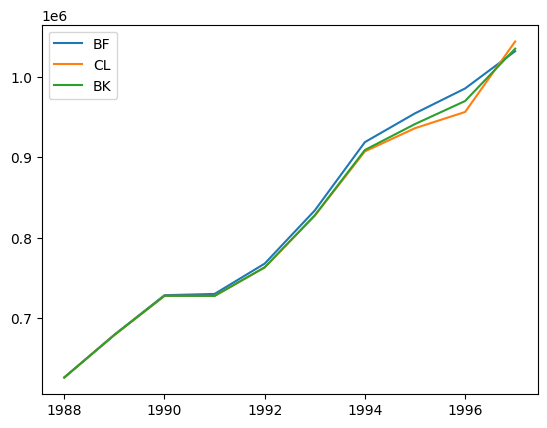

In [19]:
bk_model = cl.Benktander(apriori=0.75, n_iters=2)
bk_model.fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

plt.plot(
    bf_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    bf_model.ultimate_.to_frame(origin_as_datetime=True),
    label="BF",
)
plt.plot(
    cl_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    cl_model.ultimate_.to_frame(origin_as_datetime=True),
    label="CL",
)
plt.plot(
    bk_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    bk_model.ultimate_.to_frame(origin_as_datetime=True),
    label="BK",
)
plt.legend(loc="upper left")

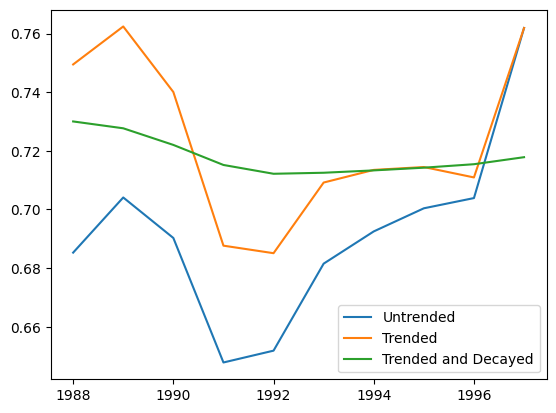

In [20]:
cc_model = cl.CapeCod(decay=0, trend=0).fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

trended_cc_model = cl.CapeCod(decay=0, trend=0.01).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

trended_decayed_cc_model = cl.CapeCod(decay=0.75, trend=0.01).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

plt.plot(
    cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Untrended",
)
plt.plot(
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Trended",
)
plt.plot(
    trended_decayed_cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_decayed_cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Trended and Decayed",
)
plt.legend(loc="lower right")

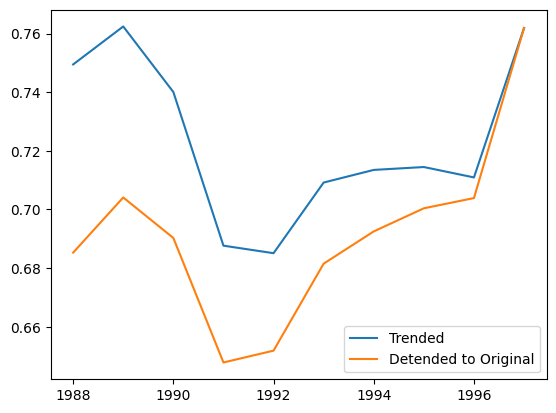

In [21]:
plt.plot(
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Trended",
)
plt.plot(
    trended_cc_model.detrended_apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_cc_model.detrended_apriori_.to_frame(origin_as_datetime=True),
    label="Detended to Original",
)
plt.legend(loc="lower right")

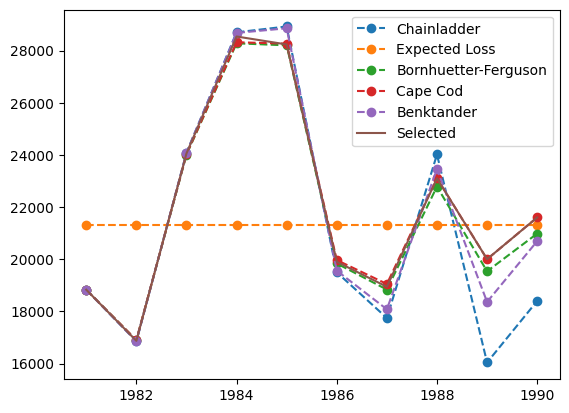

In [22]:
raa = cl.load_sample("raa")
cl_mod = cl.Chainladder()
el_mod = cl.ExpectedLoss(apriori=1)
bf_mod = cl.BornhuetterFerguson(apriori=1)
cc_mod = cl.CapeCod(decay=1, trend=0)
bk_mod = cl.Benktander(apriori=1, n_iters=2)

estimators = [
    ("cl", cl_mod),
    ("el", el_mod),
    ("bf", bf_mod),
    ("cc", cc_mod),
    ("bk", bk_mod),
]

sample_weight = cl_mod.fit(raa).ultimate_ * 0 + (
    float(cl_mod.fit(raa).ultimate_.values.sum()) / 10
)

model_weights = np.array(
    [[0.6, 0, 0.2, 0.2, 0]] * 4 + [[0, 0, 0.5, 0.5, 0]] * 3 + [[0, 0, 0, 1, 0]] * 3
)

vot_mod = cl.VotingChainladder(estimators=estimators, weights=model_weights).fit(
    raa, sample_weight=sample_weight
)

plt.plot(
    cl_mod.fit(raa).ultimate_.to_frame(origin_as_datetime=True).index.year,
    cl_mod.fit(raa).ultimate_.to_frame(origin_as_datetime=True),
    label="Chainladder",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    el_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    el_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Expected Loss",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    bf_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    bf_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Bornhuetter-Ferguson",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    cc_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    cc_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Cape Cod",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    bk_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    bk_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Benktander",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    vot_mod.ultimate_.to_frame(origin_as_datetime=True).index.year,
    vot_mod.ultimate_.to_frame(origin_as_datetime=True),
    label="Selected",
)
plt.legend(loc="best")

In [23]:
vot_mod.weights

array([[0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0. ]])

In [24]:
clrd = (
    cl.load_sample("clrd")
    .groupby("LOB")
    .sum()
    .loc["wkcomp", ["CumPaidLoss", "EarnedPremNet"]]
)
triang_stos_act['Pagados'].origin

PeriodIndex(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
             '2020', '2021'],
            dtype='period[Y-DEC]', name='origin')

In [25]:
triang_stos_act['Pagados'].incr_to_cum()

,12,24,36,48,60,72,84,96,108,120
2012,"37,403,838,673","68,852,858,519","79,812,758,729","87,284,438,578","94,508,676,628","101,209,228,356","105,668,629,593","108,766,686,935","111,373,378,400","113,251,888,751"
2013,"41,371,915,105","76,750,447,363","88,680,569,188","97,530,380,774","106,403,364,579","112,796,904,949","116,760,218,526","119,795,441,136","122,393,220,512",
2014,"44,962,034,695","78,370,979,732","90,403,946,214","100,470,625,158","107,905,924,301","112,712,786,838","117,103,824,707","120,396,238,819",,
2015,"48,222,544,121","83,409,430,582","96,219,637,305","105,197,470,620","111,254,401,436","116,086,716,957","120,603,829,864",,,
2016,"52,766,352,863","87,592,435,473","98,382,119,472","105,464,094,539","111,735,259,901","117,843,257,479",,,,
2017,"52,534,040,213","84,875,073,602","94,727,631,582","103,077,045,952","110,725,398,897",,,,,
2018,"50,429,556,379","75,602,189,759","86,231,478,208","95,466,981,841",,,,,,
2019,"38,330,031,128","58,129,819,741","67,133,970,317",,,,,,,
2020,"38,509,701,774","62,201,207,033",,,,,,,,
2021,"52,032,792,919",,,,,,,,,


In [26]:
mack = cl.MackChainladder().fit(triang_stos_act['Pagados'].incr_to_cum())
clrd = triang_stos_act['Pagados'].incr_to_cum()
clrd_first_lags = clrd[clrd.development <= 24][clrd.origin < "2021"]
y = clrd_first_lags.to_frame(origin_as_datetime=True).values[:, 1]
x = clrd_first_lags.to_frame(origin_as_datetime=True).values[:, 0]

model = sm.WLS(y, x, weights=(1 / x) ** 2)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            WLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              1543.
Date:                Tue, 23 Sep 2025   Prob (F-statistic):                    1.94e-10
Time:                        12:29:54   Log-Likelihood:                         -214.41
No. Observations:                   9   AIC:                                      430.8
Df Residuals:                       8   BIC:                                      431.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6750      0.043     39.284      0.000       1.577       1.773
==============================================================================
Omnibus:                        0.685   Durbin-Watson:                   0.331
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.536
Skew:                           0.065   Prob(JB):                        0.765
Kurtosis:                       1.812   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 $\frac{\sigma}{\sqrt{N}}$.

In [27]:
mack.parameter_risk_ + mack.process_risk_


,12,24,36,48,60,72,84,96,108,120,9999
2012,,,,,,,,,,,
2013,,,,,,,,,,"208,426,233","208,426,233"
2014,,,,,,,,,"326,091,489","393,532,589","393,532,589"
2015,,,,,,,,"312,326,026","461,994,549","518,281,906","518,281,906"
2016,,,,,,,"620,725,755","712,061,522","803,834,488","848,295,484","848,295,484"
2017,,,,,,"1,764,165,281","1,934,467,337","2,013,115,342","2,087,293,668","2,135,251,513","2,135,251,513"
2018,,,,,"1,775,844,705","2,513,453,880","2,677,024,258","2,767,708,362","2,849,501,817","2,906,101,603","2,906,101,603"
2019,,,,"1,371,743,738","2,103,972,209","2,632,213,232","2,779,665,811","2,867,972,316","2,945,965,481","3,001,351,343","3,001,351,343"
2020,,,"1,534,196,086","2,200,695,000","2,829,669,280","3,326,597,700","3,494,954,839","3,601,624,674","3,694,720,329","3,762,084,488","3,762,084,488"
2021,,"8,178,426,421","9,541,331,223","10,591,309,304","11,524,673,446","12,288,081,292","12,785,491,649","13,144,709,753","13,449,112,763","13,678,397,372","13,678,397,372"


In [28]:
mack.parameter_risk_**2 + mack.process_risk_**2 - mack.mack_std_err_**2

,12,24,36,48,60,72,84,96,108,120,9999
2012,,,,,,,,,,,
2013,,,,,,,,,,,
2014,,,,,,,,,,16,16
2015,,,,,,,,-8,,-16,-16
2016,,,,,,,,,,,
2017,,,,,,256,256,-256,,,
2018,,,,,256,-512,,,,,
2019,,,,256,,,,,,,
2020,,,-256,,,"1,024","1,024","-1,024",,,
2021,,,,,,"16,384",,"16,384","-16,384","-16,384","-16,384"


In [29]:
mack.total_process_risk_**2 - (mack.process_risk_**2).sum(axis="origin")

,12,24,36,48,60,72,84,96,108,120,9999
2012,,,"8,192",,,,,"16,384","16,384","16,384","16,384"


In [30]:
(mack.parameter_risk_**2 + mack.process_risk_**2).sum(axis=2).sum(axis=3) - (mack.mack_std_err_**2).sum(axis=2).sum(axis=3)

np.float64(131072.0)

In [31]:
mack.summary_

,Latest,IBNR,Ultimate,Mack Std Err
2012,"113,251,888,751",,"113,251,888,751",
2013,"122,393,220,512","2,064,379,611","124,457,600,123","147,420,581"
2014,"120,396,238,819","4,818,417,842","125,214,656,660","279,819,973"
2015,"120,603,829,864","8,308,776,800","128,912,606,664","371,065,425"
2016,"117,843,257,479","13,048,583,480","130,891,840,959","618,953,980"
2017,"110,725,398,897","18,930,266,801","129,655,665,698","1,601,870,694"
2018,"95,466,981,841","24,441,148,231","119,908,130,072","2,213,756,116"
2019,"67,133,970,317","25,165,974,454","92,299,944,771","2,346,679,318"
2020,"62,201,207,033","35,583,093,532","97,784,300,565","2,948,364,944"
2021,"52,032,792,919","84,615,716,141","136,648,509,061","10,665,491,321"


(0.0, 200000000000.0)

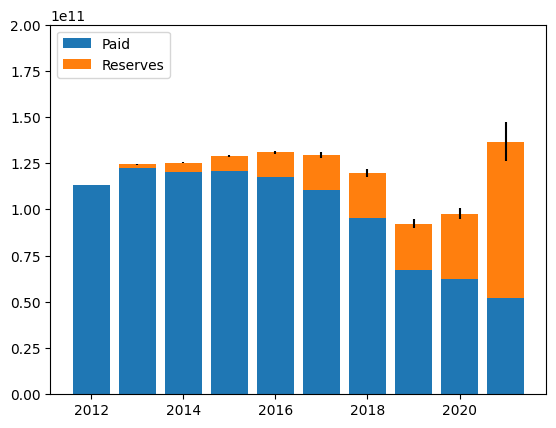

In [32]:
plt.bar(
    mack.summary_.to_frame(origin_as_datetime=True).index.year,
    mack.summary_.to_frame(origin_as_datetime=True)["Latest"],
    label="Paid",
)
plt.bar(
    mack.summary_.to_frame(origin_as_datetime=True).index.year,
    mack.summary_.to_frame(origin_as_datetime=True)["IBNR"],
    bottom=mack.summary_.to_frame(origin_as_datetime=True)["Latest"],
    yerr=mack.summary_.to_frame(origin_as_datetime=True)["Mack Std Err"],
    label="Reserves",
)
plt.legend(loc="upper left")
plt.ylim(0, 200000000000)

(array([  2.,   0.,   1.,   2.,   2.,   4.,   8.,   7.,  22.,  37.,  46.,
         67., 104., 151., 213., 254., 345., 409., 449., 504., 611., 643.,
        678., 676., 717., 662., 620., 554., 453., 424., 327., 316., 173.,
        160., 126.,  77.,  63.,  40.,  18.,  16.,   5.,   6.,   5.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([1.65888944e+11, 1.68039795e+11, 1.70190647e+11, 1.72341498e+11,
        1.74492350e+11, 1.76643202e+11, 1.78794053e+11, 1.80944905e+11,
        1.83095756e+11, 1.85246608e+11, 1.87397459e+11, 1.89548311e+11,
        1.91699162e+11, 1.93850014e+11, 1.96000865e+11, 1.98151717e+11,
        2.00302569e+11, 2.02453420e+11, 2.04604272e+11, 2.06755123e+11,
        2.08905975e+11, 2.11056826e+11, 2.13207678e+11, 2.15358529e+11,
        2.17509381e+11, 2.19660232e+11, 2.21811084e+11, 2.23961936e+11,
        2.26112787e+11, 2.28263639e+11, 2.30414490e+11, 2.32565342e+11,
        2.34716193e+11, 2.36867045e+11, 2.39017896e+11, 2.41168748e+11,
        2.

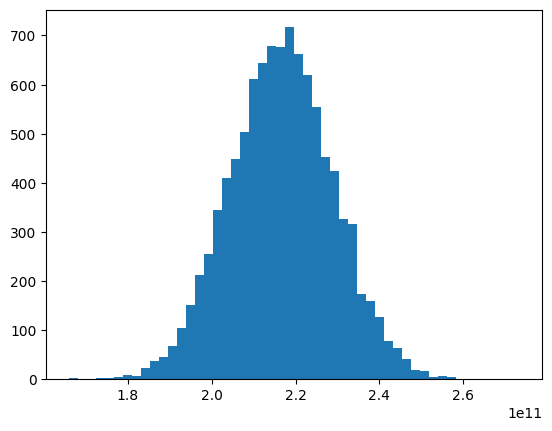

In [33]:
ibnr_mean = mack.ibnr_.sum()
ibnr_sd = mack.total_mack_std_err_.values[0, 0]
n_trials = 10000

np.random.seed(23)
dist = np.random.normal(ibnr_mean, ibnr_sd, size=n_trials)

plt.hist(dist, bins=50)

In [34]:
samples = (
    cl.BootstrapODPSample(n_sims=10000).fit(clrd).resampled_triangles_
)

In [35]:
ibnr_cl = cl.Chainladder().fit(clrd).ibnr_.sum()
ibnr_bootstrap = cl.Chainladder().fit(samples).ibnr_.sum("origin").mean()

print(
    "Chainladder's IBNR estimate:",
    ibnr_cl,
)
print(
    "BootstrapODPSample's mean IBNR estimate:",
    ibnr_bootstrap,
)
print("Difference $:", ibnr_cl - ibnr_bootstrap)
print("Difference %:", abs(ibnr_cl - ibnr_bootstrap) / ibnr_cl)

Chainladder's IBNR estimate: 216976356892.2758
BootstrapODPSample's mean IBNR estimate: 217315271146.3694
Difference $: -338914254.0935974
Difference %: 0.001561987024521115


In [36]:
pipe = cl.Pipeline(
    steps=[("dev", cl.Development(average="simple")), ("tail", cl.TailConstant(1.05))]
)

pipe.fit(samples)
pipe.named_steps.dev.ldf_.iloc[0]

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),1.7082,1.1525,1.0964,1.0748,1.0511,1.0456,1.0222,1.0206,1.0137


In [37]:
pipe

,steps,"[('dev', ...), ('tail', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_periods,-1
,average,'simple'
,sigma_interpolation,'log-linear'
,drop,None
,drop_high,None
,drop_low,None
,preserve,1


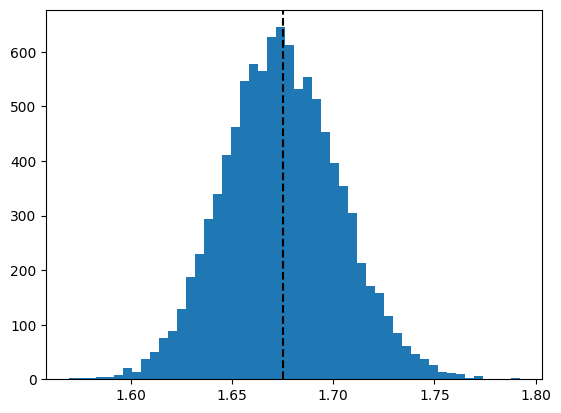

In [38]:
resampled_ldf = pipe.named_steps.dev.ldf_
plt.hist(pipe.named_steps.dev.ldf_.values[:, 0, 0, 0], bins=50)

orig_dev = cl.Development(average="simple").fit(clrd)
plt.axvline(orig_dev.ldf_.values[0, 0, 0, 0], color="black", linestyle="dashed")

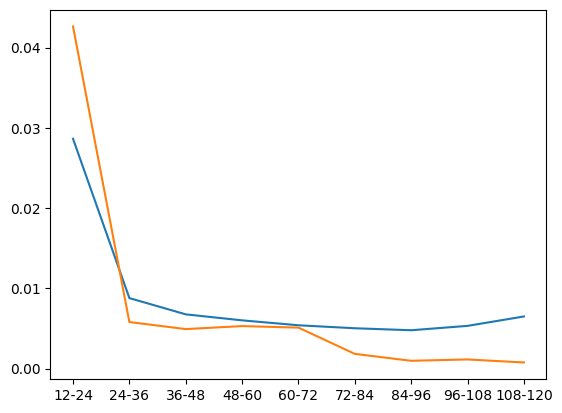

In [39]:
bootstrap_vs_mack = resampled_ldf.std("index").to_frame(origin_as_datetime=False).T
bootstrap_vs_mack.rename(columns={"(All)": "Std_Bootstrap"}, inplace=True)
bootstrap_vs_mack = bootstrap_vs_mack.merge(
    orig_dev.std_err_.to_frame(origin_as_datetime=False).T,
    left_index=True,
    right_index=True,
)
bootstrap_vs_mack.rename(columns={"(All)": "Std_Mack"}, inplace=True)

plt.plot(bootstrap_vs_mack)

([<matplotlib.axis.XTick at 0x210fa6c9450>,
 [Text(0, 0, '12-24'),
  Text(1, 0, '24-36'),
  Text(2, 0, '36-48'),
  Text(3, 0, '48-60'),
  Text(4, 0, '60-72'),
  Text(5, 0, '72-84'),
  Text(6, 0, '84-96'),
  Text(7, 0, '96-108'),
  Text(8, 0, '108-120')])

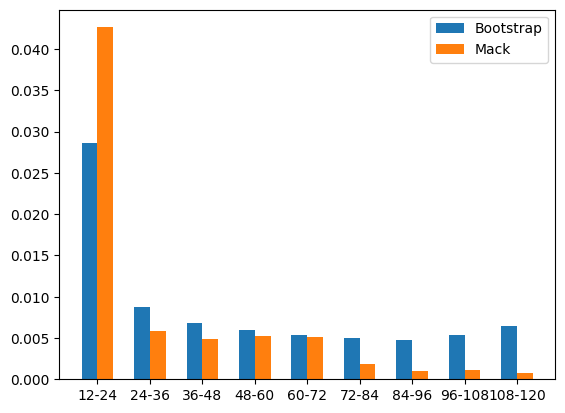

In [40]:
width = 0.3
ages = np.arange(len(bootstrap_vs_mack))

plt.bar(
    ages - width / 2,
    bootstrap_vs_mack["Std_Bootstrap"],
    width=width,
    label="Bootstrap",
)
plt.bar(ages + width / 2, bootstrap_vs_mack["Std_Mack"], width=width, label="Mack")
plt.legend(loc="upper right")
plt.xticks(ages, bootstrap_vs_mack.index)

In [41]:
aaaaa = cl.Chainladder().fit(samples)

(0.0, 200000000000.0)

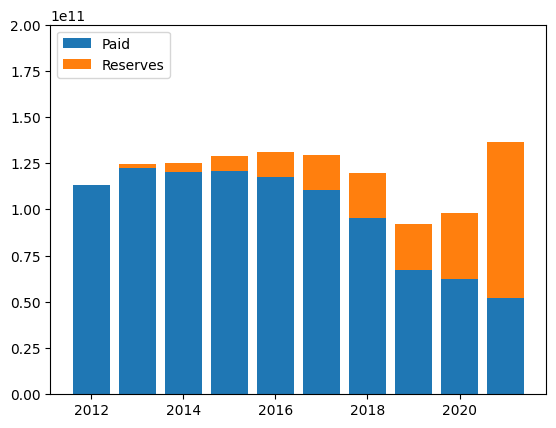

In [42]:
plt.bar(
    clrd.latest_diagonal.to_frame(origin_as_datetime=True).index.year,
    clrd.latest_diagonal.to_frame(origin_as_datetime=True).iloc[:,0],
    label="Paid",
)

plt.bar(
    aaaaa.ibnr_.mean().to_frame(origin_as_datetime=True).index.year,
    aaaaa.ibnr_.mean().to_frame(origin_as_datetime=True)['2261'],
    bottom=clrd.latest_diagonal.to_frame(origin_as_datetime=True).iloc[:,0],
    label="Reserves",
)
plt.legend(loc="upper left")
plt.ylim(0, 200000000000)

In [43]:
ibnr = cl.Chainladder().fit(samples).ibnr_.sum("origin")

ibnr_std = ibnr.std()
print("Standard deviation of reserve estimate: " + f"{round(ibnr_std,0):,}")
ibnr_99 = ibnr.quantile(q=0.99)
print("99th percentile of reserve estimate: " + f"{round(ibnr_99,0):,}")

Standard deviation of reserve estimate: 13,362,555,094.0
99th percentile of reserve estimate: 247,786,219,214.0


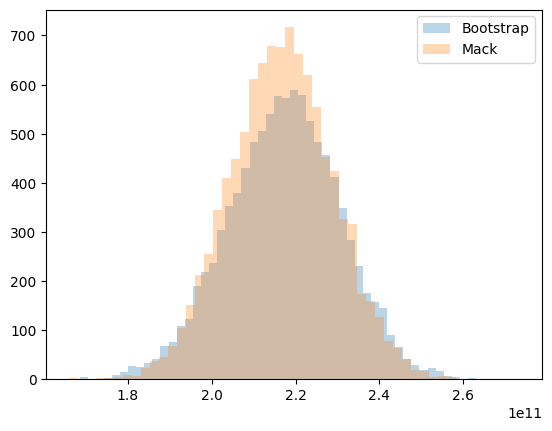

In [44]:
plt.hist(ibnr.to_frame(origin_as_datetime=True), bins=50, label="Bootstrap", alpha=0.3)
plt.hist(dist, bins=50, label="Mack", alpha=0.3)
plt.legend(loc="upper right")